## Cross-cancer prediction analysis

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
cross_cancer_dir = os.path.join(cfg.results_dir, 'cross_cancer', 'cross_cancer')
cross_cancer_df = au.load_prediction_results_cc(cross_cancer_dir, 'cross_cancer')
print(cross_cancer_df.shape)
cross_cancer_df.head()

(3456, 8)


,auroc,aupr,train_identifier,test_identifier,signal,seed,data_type,experiment
0,0.92601,0.555590,NRAS_COAD,PTEN_SKCM,shuffled,42,train,cross_cancer
1,0.50530,0.092270,NRAS_COAD,PTEN_SKCM,shuffled,42,test,cross_cancer
2,0.48782,0.061438,NRAS_COAD,PTEN_SKCM,shuffled,42,cv,cross_cancer
0,0.53141,0.063640,NF1_LGG,TTN_GBM,shuffled,42,train,cross_cancer
1,0.54635,0.332380,NF1_LGG,TTN_GBM,shuffled,42,test,cross_cancer


In [3]:
# get rows that have the same identifier
cross_cancer_df['train_test_equal'] = (cross_cancer_df.train_identifier ==
                                       cross_cancer_df.test_identifier)
# get rows that have the same gene (possibly different identifiers)
cross_cancer_df['gene_equal'] = (cross_cancer_df.train_identifier.str.split('_', expand=True)[0] ==
                                 cross_cancer_df.test_identifier.str.split('_', expand=True)[0])

Text(0.5, 1.0, 'Cross-cancer performance, same train/test gene highlighted')

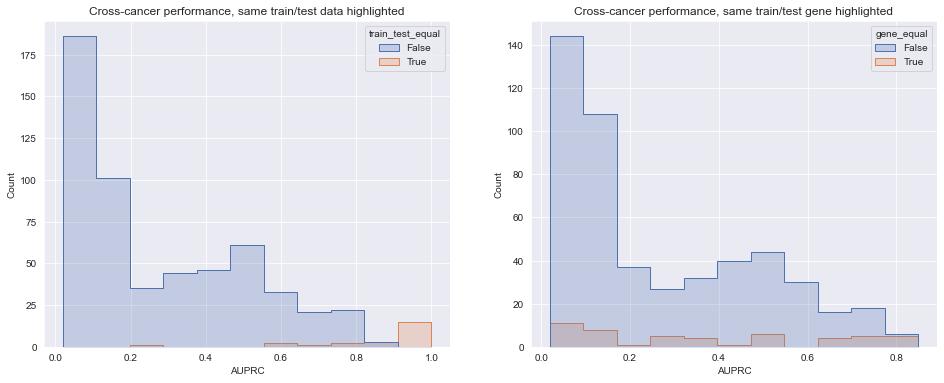

In [8]:
sns.set({'figure.figsize': (16, 6)})
fig, axarr = plt.subplots(1, 2)

sns.histplot(data=cross_cancer_df[(cross_cancer_df.signal == 'signal') &
                                  (cross_cancer_df.data_type == 'test')],
             x='aupr', stat='count', hue='train_test_equal', element='step',
             kde=False, ax=axarr[0])
axarr[0].set_xlabel('AUPRC')
axarr[0].set_ylabel('Count')
axarr[0].set_title('Cross-cancer performance, same train/test data highlighted')
sns.histplot(data=cross_cancer_df[(cross_cancer_df.signal == 'signal') &
                                  (cross_cancer_df.data_type == 'test') &
                                  (~cross_cancer_df.train_test_equal)],
             x='aupr', stat='count', hue='gene_equal', element='step',
             kde=False, ax=axarr[1])
axarr[1].set_xlabel('AUPRC')
axarr[1].set_ylabel('Count')
axarr[1].set_title('Cross-cancer performance, same train/test gene highlighted')

In [10]:
count_unique_ids = np.unique(cross_cancer_df.train_identifier).shape[0]
print(count_unique_ids)

24


In [32]:
# filter cross-cancer data and make a deep copy
# (this avoids SettingWithCopyError)
heatmap_df = (
    cross_cancer_df[(cross_cancer_df.signal == 'signal') &
                    (cross_cancer_df.data_type == 'test')].copy(deep=True)
)
    
# order using config order
heatmap_df['train_gene'] = pd.Categorical(
    heatmap_df.train_identifier.str.split('_', expand=True)[0],
    categories=cfg.cross_cancer_genes)
heatmap_df.sort_values('train_gene', inplace=True)
sorted_train_ids = pd.unique(heatmap_df.train_identifier)

# then pivot to wideform heatmap and re-sort
# (pivot sorts indexes alphabetically by default, so we have to override that)
heatmap_df = heatmap_df.pivot(index='train_identifier', columns='test_identifier', values='aupr')
heatmap_df = heatmap_df.reindex(sorted_train_ids)
heatmap_df = heatmap_df.reindex(sorted_train_ids, axis=1)

heatmap_df.iloc[:5, :5]

test_identifier,KRAS_COAD,NRAS_THCA,NRAS_COAD,NRAS_SKCM,BRAF_SKCM
train_identifier,,,,,
KRAS_COAD,0.95576,0.044197,0.070596,0.32623,0.62135
NRAS_THCA,0.42134,0.806650,0.057936,0.29792,0.59866
NRAS_COAD,0.56532,0.055429,0.680040,0.30188,0.48918
NRAS_SKCM,0.43494,0.078442,0.095447,0.99676,0.36546
BRAF_SKCM,0.47767,0.071228,0.044046,0.18275,0.99984


<AxesSubplot:xlabel='test_identifier', ylabel='train_identifier'>

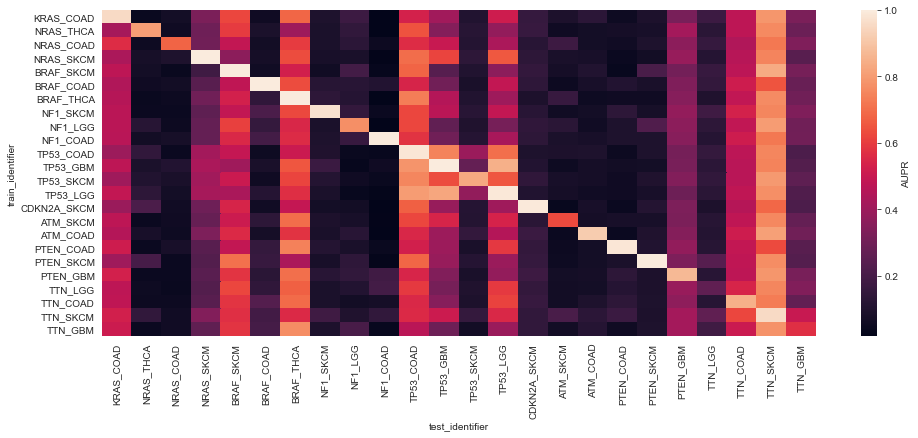

In [31]:
sns.heatmap(heatmap_df, cbar_kws={'label': 'AUPR'})
plt.title('AUPR values')